In [1]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import DataLoader

import sys 

sys.path.insert(1, 'D:/IPS_PCA_CLUSTERING-the_end/')

from copy import deepcopy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# custom
from src.utils.dataset import RSSIDataset
from src.utils.file_utils import read_data, load_data, load_csv
from src.utils.helper import get_current_date, normalize_data, separates_data_uts, mean_error, clip_gradient, \
    constant_columns, detect_num_feature_rssi, load_data_npz, draw_distribution_cluster, draw_kmean_distortion, \
    draw_kmean_silhouette, set_seed_everything
from src.utils.models import RegressionNet, ClassificationNet, Ensemble_Model, Ensemble_Classic_Model, train_regression, \
    train_classification, model_evaluation, classic_model_evaluation, load_model_classification, save_model_sklearn, \
    load_model_sklearn
from src.utils.loss import MeanLoss
import src.utils.regr_utils as regr

C:\Users\Asus\anaconda3\envs\RSSI\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Global config

In [2]:
N_CLUSTER = 2
NUM_IN = 150
NUM_FEATURES_RSSI = 589
SEED = 2023
N_CPU = os.cpu_count()
set_seed_everything(SEED)

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

date_str = get_current_date()
# date_str = "2023_02_05"
data_type_str = "uts"
n_cluster_str = N_CLUSTER
model_path = {
    'type': 'kernel_pca_150 | UTS | 2_cluster_label',
    'n_clusters': N_CLUSTER,
    'cluster': f'../../models/{data_type_str}_models/cluster_{n_cluster_str}/{date_str}/model_cluster.sav',
    'cluster_classifier': f'../../models/{data_type_str}_models/cluster_{n_cluster_str}/{date_str}/model_cluster_classifier.sav',
    'custom_cluster_classifier': f'../../models/{data_type_str}_models/cluster_{n_cluster_str}/{date_str}/model_custom_cluster_classifier.pth',
    'floor_classifier': f'../../models/{data_type_str}_models/cluster_{n_cluster_str}/{date_str}/model_floor_classifier.sav',
    'ensemble': f"../../models/{data_type_str}_models/cluster_{n_cluster_str}/{date_str}/ensemble_model",
    "total": f"../../models/{data_type_str}_models/cluster_{n_cluster_str}/{date_str}/model_total.pth",
}
Path(f'../../models/{data_type_str}_models/cluster_{n_cluster_str}/{date_str}/').mkdir(parents=True, exist_ok=True)
Path(f'../../models/{data_type_str}_models/cluster_{n_cluster_str}/{date_str}/ensemble_model').mkdir(parents=True,
                                                                                                     exist_ok=True)
regr_models = [
    DecisionTreeRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    KNeighborsRegressor(),
    MLPRegressor(),
    SVR(),
]

### Data Path

In [3]:
data_dir = f"../../data/{data_type_str}_data/pca/kernal_pca_cosine_{NUM_IN}/"
# data_dir = f"../../data/{data_type_str}_data/pca/pca_090"

(X_train, Y_train), (X_test, Y_test), (X_valid, Y_valid) = load_data_npz(
    [
        os.path.join(data_dir, "X_train.npz"),
        os.path.join(data_dir, "Y_train.npz"),
        os.path.join(data_dir, "X_test.npz"),
        os.path.join(data_dir, "Y_test.npz"),
        os.path.join(data_dir, "X_valid.npz"),
        os.path.join(data_dir, "Y_valid.npz")
    ]
)

In [4]:
X_train.shape

(8379, 150)

### K-Means Clustering

In [5]:
cluster = KMeans(n_clusters=N_CLUSTER).fit(Y_train[:, :2])
save_model_sklearn(model_path=model_path["cluster"], model=cluster)

Z_train = cluster.labels_
Z_test = cluster.predict(Y_test[:, :2])
Z_valid = cluster.predict(Y_valid[:, :2])

for i in np.unique(Z_valid):
    print(f"cluster valid {i}", len(Z_valid[Z_valid == i]))

for i in np.unique(Z_train):
    print(f"cluster train {i}", len(Z_train[Z_train == i]))

for i in np.unique(Z_test):
    print(f"cluster test {i}", len(Z_test[Z_test == i]))

===== Save model sklearn successfully =====
cluster valid 0 401
cluster valid 1 328
cluster train 0 4481
cluster train 1 3898
cluster test 0 227
cluster test 1 161


### Đồ thị clustering

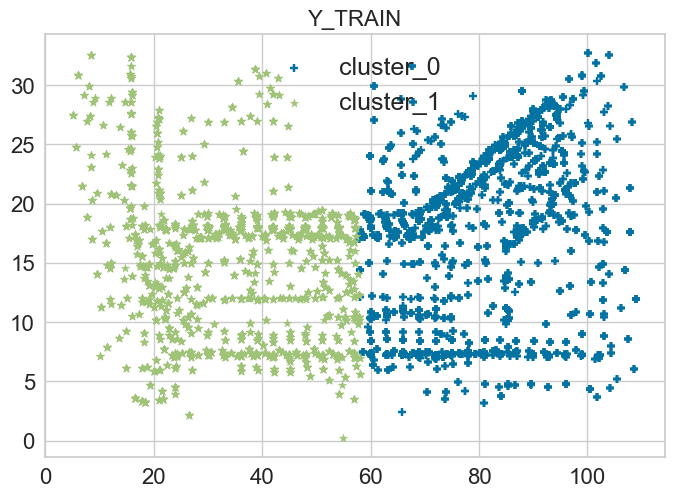

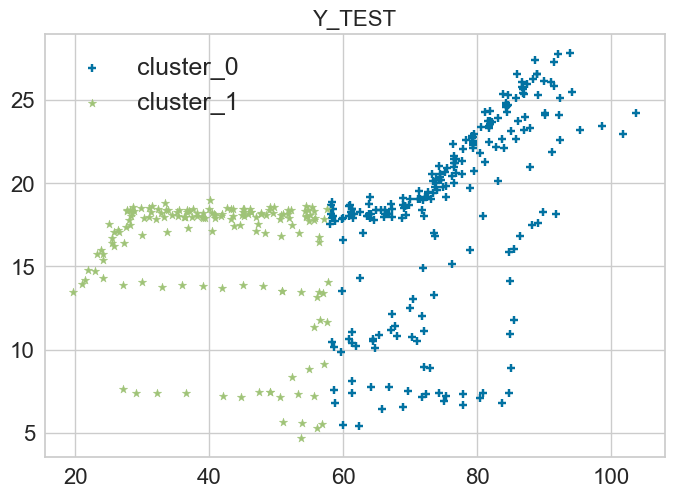

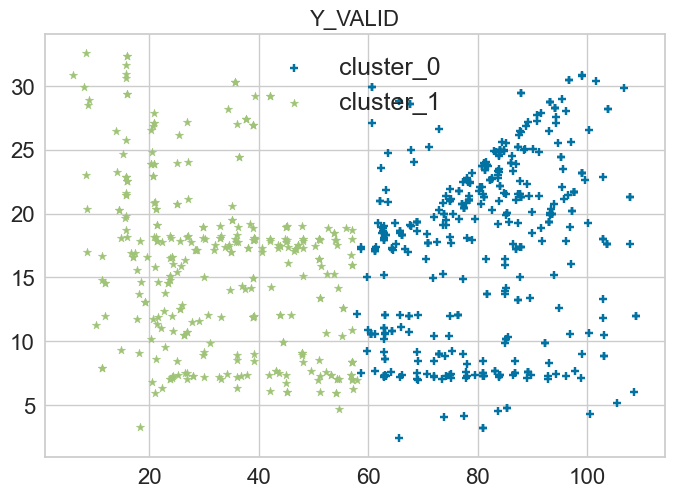

In [6]:
# phân bố dữ liệu theo cluster của label
draw_distribution_cluster(Y_train[:, :2], Z_train, title="Y_TRAIN")
draw_distribution_cluster(Y_test[:, :2], Z_test, title="Y_TEST")
draw_distribution_cluster(Y_valid[:, :2], Z_valid, title="Y_VALID")

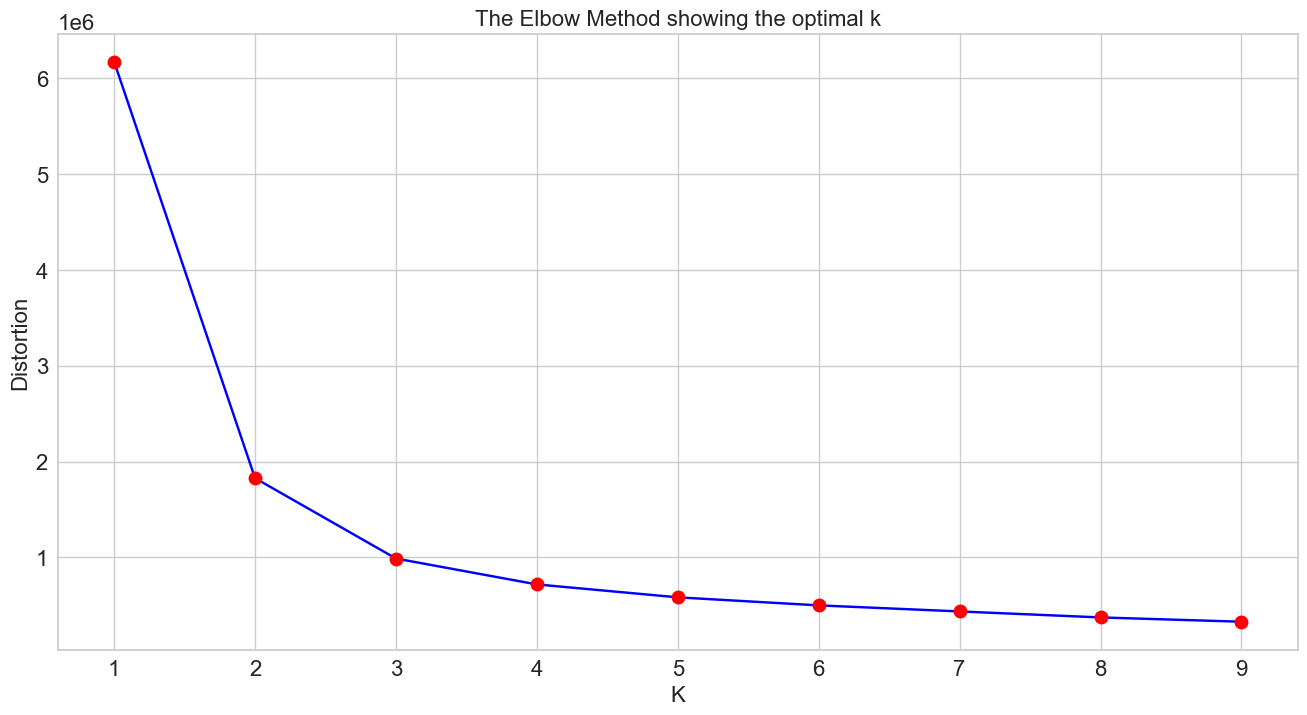

In [7]:
draw_kmean_distortion(Y_train[:, :2], range(1, 10))

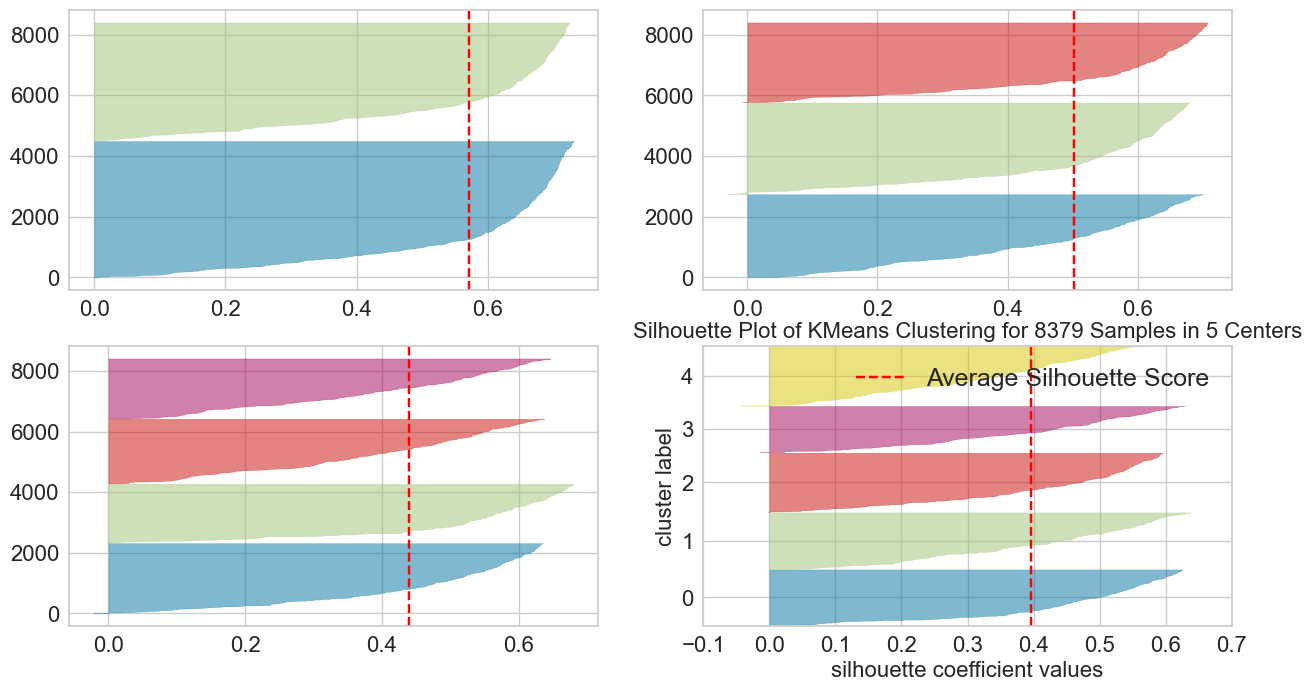

In [8]:
draw_kmean_silhouette(Y_train[:, :2], [2, 3, 4, 5])

In [9]:
# regression dataset
train_regression_data = RSSIDataset(X_train, Y_train[:, :2])
valid_regression_data = RSSIDataset(X_valid, Y_valid[:, :2])
test_regression_data = RSSIDataset(X_test, Y_test[:, :2])

train_regression_dataloader = DataLoader(train_regression_data, batch_size=16, num_workers=N_CPU, pin_memory=True, drop_last=True)
valid_regression_dataloader = DataLoader(valid_regression_data, batch_size=1, pin_memory=True)
test_regression_dataloader = DataLoader(test_regression_data, batch_size=1, pin_memory=True)

# classifier dataset
train_cluster_dataset = RSSIDataset(X_train, Z_train)
valid_cluster_dataset = RSSIDataset(X_valid, Z_valid)
test_cluster_dataset = RSSIDataset(X_test, Z_test)

train_cluster_loader = DataLoader(train_cluster_dataset, batch_size=16, num_workers=N_CPU, drop_last=True)
valid_cluster_loader = DataLoader(valid_cluster_dataset, batch_size=1)
test_cluster_loader = DataLoader(test_cluster_dataset, batch_size=1)

### Train and validate classification models

In [10]:
clf1 = GaussianNB()
clf2 = MLPClassifier()
clf3 = SVC(kernel='rbf', probability=True)

eclf = VotingClassifier(
    estimators=[
        ('clf1', clf1), ('clf2', clf2), ('clf3', clf3)
    ],
    voting="soft",
    weights=[3, 1, 2]
)

print(f"Train clf1 model: {clf1.__class__.__name__}")
clf1 = clf1.fit(X_train, Z_train)
print(f"Train clf2 model: {clf2.__class__.__name__}")
clf2 = clf2.fit(X_train, Z_train)
print(f"Train clf3 model: {clf3.__class__.__name__}")
clf3 = clf3.fit(X_train, Z_train)
print(f"Train eclf model: {eclf.__class__.__name__}")
eclf = eclf.fit(X_train, Z_train)

print(clf1.score(X_test, Z_test))
print(clf2.score(X_test, Z_test))
print(clf3.score(X_test, Z_test))
print(eclf.score(X_test, Z_test))

save_model_sklearn(model_path["cluster_classifier"], eclf)

Train clf1 model: GaussianNB
Train clf2 model: MLPClassifier
Train clf3 model: SVC
Train eclf model: VotingClassifier
0.9149484536082474
0.8814432989690721
0.884020618556701
0.904639175257732
===== Save model sklearn successfully =====


In [11]:
loaded_model = load_model_sklearn(model_path["cluster_classifier"])
result = loaded_model.score(X_test, Z_test)
print("\nFinal")
print(result)

===== Load model sklearn successfully =====

Final
0.904639175257732


### Train custom cluster classifier

In [12]:
# net = ClassificationNet(num_in=NUM_IN, num_out=2)
#
# weight_path = model_path["custom_cluster_classifier"]
# train_classification(
#     net,
#     X_train,
#     Z_train,
#     X_valid,
#     Z_valid,
#     weight_path)

In [13]:
# weight_path = model_path["custom_cluster_classifier"]
# net = load_model_classification(weight_path, num_in=100, num_out=2)
# net.score(X_test, Z_test)

### Train Ensemble

In [14]:
# train model cluster
ens_model = Ensemble_Model(n_cluster=N_CLUSTER, num_in=NUM_IN, ensemble_model_path=model_path["ensemble"])
ens_model.train_student(X_train, Y_train[:,:2], Z_train, X_valid, Y_valid[:,:2], Z_valid)

# classic
# ens_model = Ensemble_Classic_Model(models=regr_models, ensemble_model_path=model_path["ensemble"])
# ens_model.train_student(X_train, Y_train[:, :2], Z_train, X_valid, Y_valid[:, :2], Z_valid)


 ========== Training cluster 0 with dataset contain 4481 train samples and 401 valid samples ==========



Epoch 1 val: 100%|████████████████████████████████| 401/401 [00:00<00:00, 464.57batch/s, AVG_LOSS=14.4, LOSS_ITER=25.2]


                                                                                                     Best valid loss: 14.4064


Epoch 2 val: 100%|███████████████████████████████| 401/401 [00:00<00:00, 438.95batch/s, AVG_LOSS=13.1, LOSS_ITER=0.656]


                                                                                                     Best valid loss: 13.1435


Epoch 4 val: 100%|████████████████████████████████| 401/401 [00:00<00:00, 408.40batch/s, AVG_LOSS=12.7, LOSS_ITER=4.69]


                                                                                                     Best valid loss: 12.6746


Epoch 38 val: 100%|███████████████████████████████| 401/401 [00:00<00:00, 512.09batch/s, AVG_LOSS=22.2, LOSS_ITER=17.1]


Epoch 50 val: 100%|███████████████████████████████| 401/401 [00:00<00:00, 591.93batch/s, AVG_LOSS=17.4, LOSS_ITER=14.1]



 ========== Training cluster 1 with dataset contain 3898 train samples and 328 valid samples ==========



Epoch 1 val: 100%|████████████████████████████████| 328/328 [00:00<00:00, 605.87batch/s, AVG_LOSS=15.4, LOSS_ITER=9.18]


                                                                                                     Best valid loss: 15.3819


Epoch 2 val: 100%|████████████████████████████████| 328/328 [00:00<00:00, 565.44batch/s, AVG_LOSS=13.1, LOSS_ITER=8.09]


                                                                                                     Best valid loss: 13.1332


Epoch 36 val: 100%|███████████████████████████████| 328/328 [00:00<00:00, 493.56batch/s, AVG_LOSS=23.7, LOSS_ITER=28.9]


Epoch 50 val: 100%|█████████████████████████████████| 328/328 [00:00<00:00, 577.81batch/s, AVG_LOSS=20, LOSS_ITER=22.2]


### Train Total Model

In [15]:
# Training total regression model
loss_list, loss_eval, weight = train_regression(
    model=RegressionNet(cluster=False, n_cluster=N_CLUSTER, num_in=NUM_IN),
    metric=MeanLoss(),
    train_dataloader=train_regression_dataloader,
    valid_dataloader=valid_regression_dataloader,
    weight_path=model_path["total"])

# regr.train_multiple_labels(
#     regr_models,
#     X_train, Y_train[:, :2],
#     X_valid, Y_valid[:, :2],
#     model_path["total"])

Epoch 1 val: 100%|████████████████████████████████| 729/729 [00:01<00:00, 541.87batch/s, AVG_LOSS=26.6, LOSS_ITER=11.4]


                                                                                                     Best valid loss: 26.6386


Epoch 35 val: 100%|███████████████████████████████| 729/729 [00:01<00:00, 457.48batch/s, AVG_LOSS=29.2, LOSS_ITER=6.29]


Epoch 50 val: 100%|███████████████████████████████| 729/729 [00:01<00:00, 455.40batch/s, AVG_LOSS=29.3, LOSS_ITER=6.34]


### Eval All Regression

In [16]:
model_evaluation(
    model_total_path=model_path["total"],
    model_dict_path=[
        os.path.join(model_path["ensemble"], "model_0.pth"),
        os.path.join(model_path["ensemble"], "model_1.pth"),
        # os.path.join(model_path["ensemble"], "model_2.pth"),
        # "../../models/uts_models/2023_02_04/ensemble_model/model_2.pth",
    ],
    model_cluster_classifier_path=model_path["cluster_classifier"],
    model_cluster_path=model_path["cluster"],
    metric=MeanLoss(),
    num_in=NUM_IN,
    X_test=X_test,
    Y_test=Y_test[:,:2])

# classic_model_evaluation(
#     model_total_path=model_path["total"],
#     model_dict_path=[
#         os.path.join(model_path["ensemble"], "model_0.sav"),
#         os.path.join(model_path["ensemble"], "model_1.sav"),
#         # os.path.join(model_path["ensemble"], "model_2.sav"),
#         # os.path.join(model_path["ensemble"], "model_3.sav"),
#     ],
#     model_cluster_classifier_path=model_path["cluster_classifier"],
#     model_cluster_path=model_path["cluster"],
#     X_test=X_test,
#     Y_test=Y_test[:, :2])

===== Load model sklearn successfully =====
===== Load model sklearn successfully =====
Cluster 0 loss:  6.7933082393966275
Cluster 1 loss:  7.6847091687012865
total loss: 7.174680801934188
